# Model Validation

Create a plot to compare CESM-LENS climatology to neural network climatology.

In [108]:
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import esmtools as et
from mpl_toolkits.basemap import Basemap
from matplotlib import gridspec

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [2]:
EBUS = ['CalCS', 'HumCS', 'CanCS', 'BenCS']

# CESM-LENS Manipulation

In [89]:
idx = 'CalCS'
lens_output, lens_lat, lens_lon = ( {} for i in range(3) )
print(('Operating on : %s ...') %idx)
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/' + idx + '/'
if idx == 'CalCS' or idx == 'HumCS' :
    ds_lens = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')
else:
     ds_lens = xr.open_mfdataset(fileDir + 'extended_domain/' + 'extended_domain*.nc', concat_dim='ensemble')


Operating on : CalCS ...


In [90]:
if idx == 'HumCS':
    ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
    ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'])
else:
    ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
    ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'][0])

In [91]:
ds_lens = ds_lens.mean(dim='ensemble')

In [92]:
x0,x1,y0,y1 = et.ebus.visual_bounds(idx)
a, c = et.filtering.find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
                    y0, x0)
b, d = et.filtering.find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
                    y1, x1)

In [93]:
ds_lens = ds_lens.isel(nlat=slice(a, b), nlon=slice(c,d))
ds_lens = ds_lens.sel(time=slice('1982-01', '2015-12')).mean(dim='time')
lens_output[idx] = pd.DataFrame(ds_lens['FG_CO2'].values)
lens_lat[idx] = pd.DataFrame(ds_lens['TLAT'].values)
lens_lon[idx] = pd.DataFrame(ds_lens['TLONG'].values)
del ds_lens

/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [96]:
lens_output, lens_lat, lens_lon = ( {} for i in range(3) )
for idx in EBUS:
    print(('Operating on : %s ...') %idx)
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/' + idx + '/'
    if idx == 'CalCS' or idx == 'HumCS' :
        ds_lens = xr.open_mfdataset(fileDir + '*.nc', concat_dim='ensemble')
    else:
        ds_lens = xr.open_mfdataset(fileDir + 'extended_domain/' + 'extended_domain*.nc', concat_dim='ensemble')
    # Fix quirk where TLAT/TLONG are coordinates which dissapear when you do ensemble mean.
    if idx == 'HumCS':
        ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
        ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'])
    else:
        ds_lens['TLAT'] = (('nlat', 'nlon'), ds_lens['TLAT'][0])
        ds_lens['TLONG'] = (('nlat', 'nlon'), ds_lens['TLONG'][0])
    ds_lens = ds_lens.mean(dim='ensemble')
    x0,x1,y0,y1 = et.ebus.visual_bounds(idx, std_lon=False)
#    if idx != 'BenCS':
#        x0,x1,y0,y1 = et.ebus.visual_bounds(idx, std_lon=True)
#    else:
#        x0,x1,y0,y1 = et.ebus.visual_bounds(idx, std_lon=False)
    a, c = et.filtering.find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
                    y0, x0)
    b, d = et.filtering.find_indices(ds_lens['TLAT'].values, ds_lens['TLONG'].values,
                    y1, x1)
    ds_lens = ds_lens.isel(nlat=slice(a, b), nlon=slice(c,d))
    ds_lens = ds_lens.sel(time=slice('1982-01', '2015-12')).mean(dim='time')
    lens_output[idx] = pd.DataFrame(ds_lens['FG_CO2'].values)
    lens_lat[idx] = pd.DataFrame(ds_lens['TLAT'].values)
    lens_lon[idx] = pd.DataFrame(ds_lens['TLONG'].values)
    del ds_lens

Operating on : CalCS ...


/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Operating on : HumCS ...
Operating on : CanCS ...
Operating on : BenCS ...


# SOM-FFN Manipulation

In [23]:
obs_output, obs_lat, obs_lon = ( {} for i in range(3) )
fileDir = '/glade/p/work/rbrady/Landschuetzer_pCO2/'
ds_obs = xr.open_dataset(fileDir + 'spco2_1982-2015_MPI_SOM-FFN_v2016.nc', decode_times=False)
times = pd.date_range('1982-01', '2016-01', freq='M')
ds_obs['time'] = times
ds_obs.attrs = {}
X, Y = np.meshgrid(ds_obs['lon'].values, ds_obs['lat'].values)
ds_obs['LON'] = (('lat','lon'), X)
ds_obs['LAT'] = (('lat','lon'), Y)
ds_obs = ds_obs.mean(dim='time')
for idx in EBUS:
    print(('Operating on : %s ...') %idx)
    x0,x1,y0,y1 = et.ebus.visual_bounds(idx, std_lon=True)
    a, c = et.filtering.find_indices(ds_obs['LAT'].values, ds_obs['LON'].values,
                    y0, x0)
    b, d = et.filtering.find_indices(ds_obs['LAT'].values, ds_obs['LON'].values,
                    y1, x1)  
    ds_temp = ds_obs.isel(lat=slice(a,b), lon=slice(c,d))
    temp_data = ds_obs['fgco2_raw'].values
    mask = ( temp_data > 1e19 )
    temp_data[mask] = np.nan
    obs_output[idx] = pd.DataFrame(ds_temp['fgco2_raw'].values)
    obs_lat[idx] = pd.DataFrame(ds_temp['LAT'].values)
    obs_lon[idx] = pd.DataFrame(ds_temp['LON'].values)
    del ds_temp                                    

Operating on : CalCS ...
Operating on : HumCS ...
Operating on : CanCS ...
Operating on : BenCS ...


/glade/u/home/rbrady/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater


# Visualization

In [102]:
idx='CalCS'

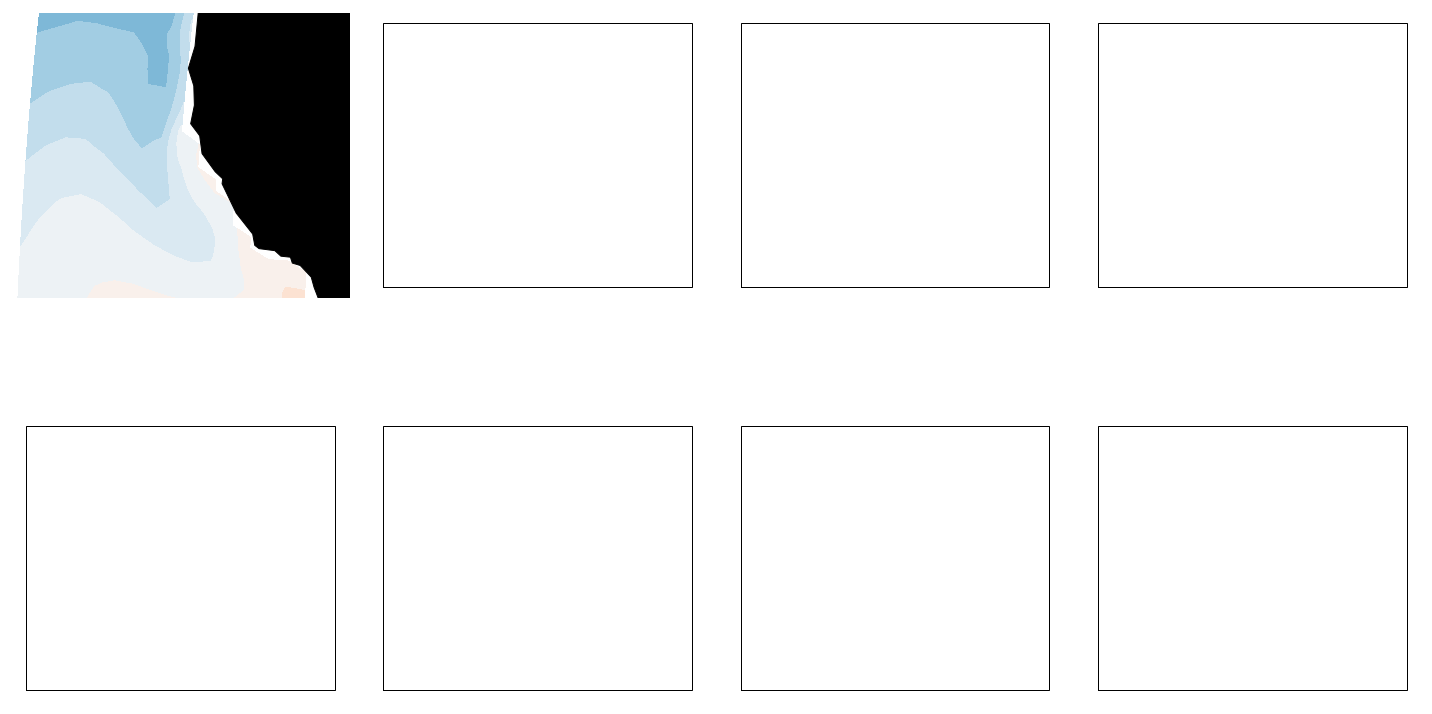

In [107]:
f, ax = plt.subplots(nrows=2, ncols=4, figsize=(20,12), subplot_kw=dict(projection=ccrs.Mercator()))

ax[0,0].contourf(lens_lon[idx], lens_lat[idx], lens_output[idx], np.linspace(-2.5,2.5,num=21,endpoint=True),
                 transform=ccrs.PlateCarree(), cmap="RdBu_r", extend="both")
x0,x1,y0,y1 = et.ebus.visual_bounds(idx)
ax[0,0].set_extent([x0,x1,y0,y1])
ax[0,0].add_feature(cfeature.LAND, facecolor='k')
ax[0,0].outline_patch.set_edgecolor('white')

f.tight_layout()

In [ ]:
names = ['California Current',
         'Humboldt Current',
         'Canary Current',
         'Benguela Current']
fig = plt.figure(figsize=(20,12))
counter_top = 1
counter_mid = 5
for idx in EBUS:
    # Landscheutzer Climatology (Top)
    ax = fig.add_subplot(2, 4, counter_top)
    m = map_upwelling_clim(ax, idx, 'obs')
    if counter_top == 1:
        plt.ylabel('Landschuetzer et al. 2015 (1982-2011)', size=18)    
    plt.title(names[counter_top-1], size=25)
    counter_top += 1
    # CESM-LENS Climatology (Middle)
    ax = fig.add_subplot(2, 4, counter_mid)
    m = map_upwelling_clim(ax, idx, 'model')
    if counter_mid == 5:
        plt.ylabel('CESM Large Ensemble (1982-2011)', size=18)   
    cbar = m.colorbar(location="bottom")
    cbar.set_ticks(np.arange(-2, 2.1, 1))
    cbar.ax.tick_params(labelsize=20, direction='out') 
    cbar.set_label('Sea-Air CO$_{2}$ Flux (mol/m$^{2}$/yr)', size=20)
    counter_mid +=1
fig.tight_layout()

et.vis.savefig('model-evaluation')
#plt.savefig('landschuetzer-model-climatological-comparison-withLon.eps', transparent=True, format='eps', 
#            bbox_inches='tight', pad_inches=1, dpi=1000)

In [ ]:
def setup_map(ax, lat1, lat2, lon1, lon2, lonlabel=False):
    m = Basemap(projection='merc',
                lat_0=(lat1+lat2)/2,
                lon_0=(lon1+lon2)/2,
                #width=(2000*1000),
                #height=(2000*1000),
                llcrnrlon=lon1,
                urcrnrlon=lon2,
                llcrnrlat=lat1,
                urcrnrlat=lat2,
                fix_aspect=False,
                resolution='c')
    m.drawcoastlines(color='#D3D3D3')
    #m.drawcountries()
    #m.drawstates()
    m.fillcontinents(color='#D3D3D3')
    m.drawmapboundary(fill_color='white')
    m.drawparallels(np.arange(lat1, lat2+1, 3),
                   labels=[False,True,False,False], size=20,
                   color='w')
    m.drawmeridians(np.arange(lon1, lon2+1, 2),
                   labels=[False, False, False, False], size=20,
                   color='w')
    return m

In [ ]:
def map_upwelling_clim(ax, EBU, typ):
    if typ == 'obs':
        lon = obs_lon[EBU].values
        lat = obs_lat[EBU].values
        data = obs_output[EBU].values
        data = np.ma.array(data, mask=np.isnan(data))
    elif typ == 'model':
        lon = lens_lon[EBU].values
        lat = lens_lat[EBU].values
        data = lens_output[EBU].values
        data = np.ma.array(data, mask=np.isnan(data))
    lat1,lat2,lon1,lon2 = visual_bounds(EBU)
    if typ == 'model' and EBU != 'BenCS':
        lon1 = 360 + lon1; lon2 = 360 + lon2;
    if typ == 'obs':
        m = setup_map(ax, lat1, lat2, lon1, lon2)
    elif typ == 'model':
        m = setup_map(ax, lat1, lat2, lon1, lon2, lonlabel=True)
    m.contourf(lon, lat, data, np.linspace(-2.5, 2.5, num=21, endpoint=True),
               latlon=True, cmap="RdBu_r", extend="both")
    return m